In [8]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt


In [14]:
model = pybamm.BaseModel()

# define parameters
electrodes = ["negative", "positive"]
I = pybamm.FunctionParameter("Current function [A]", {"Time [s]": pybamm.t})
D_i = [pybamm.Parameter(f"{e.capitalize()} particle diffusivity [m2.s-1]") for e in electrodes]
R_i = [pybamm.Parameter(f"{e.capitalize()} particle radius [m]") for e in electrodes]
c0_i = [pybamm.Parameter(f"Initial concentration in {e} electrode [mol.m-3]") for e in electrodes]
delta_i = [pybamm.Parameter(f"{e.capitalize()} electrode thickness [m]") for e in electrodes]
A = pybamm.Parameter("Electrode width [m]") * pybamm.Parameter("Electrode height [m]")  # PyBaMM takes the width and height of the electrodes (assumed rectangular) rather than the total area
epsilon_i = [pybamm.Parameter(f"{e.capitalize()} electrode active material volume fraction") for e in electrodes]

# define universal constants (PyBaAMM has them built in)
F = pybamm.constants.F

# define variables that depend on the parameters
a_i = [3 * epsilon_i[i] / R_i[i] for i in [0, 1]]
j_i = [I / a_i[0] / delta_i[0] / F / A, -I / a_i[1] / delta_i[1] / F / A]

# define state variables
c_i = [pybamm.Variable(f"{e.capitalize()} particle concentration [mol.m-3]", domain=f"{e} particle") for e in electrodes]

# governing equations
dcdt_i = [pybamm.div(D_i[i] * pybamm.grad(c_i[i])) for i in [0, 1]]
model.rhs = {c_i[i]: dcdt_i[i] for i in [0, 1]}

# boundary conditions
lbc = pybamm.Scalar(0)
rbc = [-j_i[i] / D_i[i] for i in [0, 1]]
model.boundary_conditions = {c_i[i]: {"left": (lbc, "Neumann"), "right": (rbc[i], "Neumann")} for i in [0, 1]}

# initial conditions
model.initial_conditions = {c_i[i]: c0_i[i] for i in [0, 1]}


this notation is equivalent to:

D_i = []
for e in electrodes:
    param = pybamm.Parameter(f"{e.capitalize()} electrode diffusivity [m2.s-1]")
    D_i.append(param)

In [15]:
# call universal constants (PyBaMM has them built in)
R = pybamm.constants.R

# define temperature
T = pybamm.Parameter("Ambient temperature [K]")

# define new parameters for the output variables
c_e = pybamm.Parameter("Initial concentration in electrolyte [mol.m-3]")
k_i = [pybamm.Parameter(f"{e.capitalize()} electrode reaction rate [m.s-1]") for e in electrodes]
c_i_max = [pybamm.Parameter(f"Maximum concentration in {e} electrode [mol.m-3]") for e in electrodes]

# define intermediate variables and OCP function parameters
c_i_s = [pybamm.surf(c_i[i]) for i in [0, 1]]
x_i_s = [c_i_s[i] / c_i_max[i] for i in [0, 1]]
i_0_i = [k_i[i] * F * (pybamm.sqrt(c_e) * pybamm.sqrt(c_i_s[i]) * pybamm.sqrt(c_i_max[i] - c_i_s[i])) for i in [0, 1]]
eta_i = [2 * R * T / F * pybamm.arcsinh(j_i[i] * F / (2 * i_0_i[i])) for i in [0, 1]]
U_i = [pybamm.FunctionParameter(f"{e.capitalize()} electrode OCP [V]", {"stoichiometry": x_i_s[i]}) for (i, e) in enumerate(electrodes)]

# define output variables
[U_n_plus_eta, U_p_plus_eta] = [U_i[i] + eta_i[i] for i in [0, 1]]
V = U_p_plus_eta - U_n_plus_eta
model.variables = {
  "Voltage [V]": V,
  "Negative particle surface concentration [mol.m-3]": c_i_s[0],
}

In [16]:
param = pybamm.ParameterValues("Chen2020")
# PyBaMM parameters provide the exchange current density directly, rather than the reaction rate, so define here
param.update({
    "Positive electrode reaction rate [m.s-1]": 1e-3,
    "Negative electrode reaction rate [m.s-1]": 1e-3,
}, check_already_exists=False)

In [17]:
# create geometry
r_i = [pybamm.SpatialVariable("r", domain=[f"{e} particle"], coord_sys="spherical polar") for e in electrodes]
geometry = {f"{e} particle": {r_i[i]: {"min": pybamm.Scalar(0), "max": R_i[i]}} for (i, e) in enumerate(electrodes)}


In [18]:
# create geometry
r_i = [pybamm.SpatialVariable("r", domain=[f"{e} particle"], coord_sys="spherical polar") for e in electrodes]
geometry = {f"{e} particle": {r_i[i]: {"min": pybamm.Scalar(0), "max": R_i[i]}} for (i, e) in enumerate(electrodes)}

param.process_model(model)
param.process_geometry(geometry)

# meshs
submesh_types = {f"{e} particle": pybamm.Uniform1DSubMesh for e in electrodes}
var_pts = {r: 20 for r in r_i}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

# spatial methods
spatial_methods = {f"{e} particle": pybamm.FiniteVolume() for e in electrodes}

# discretise model
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

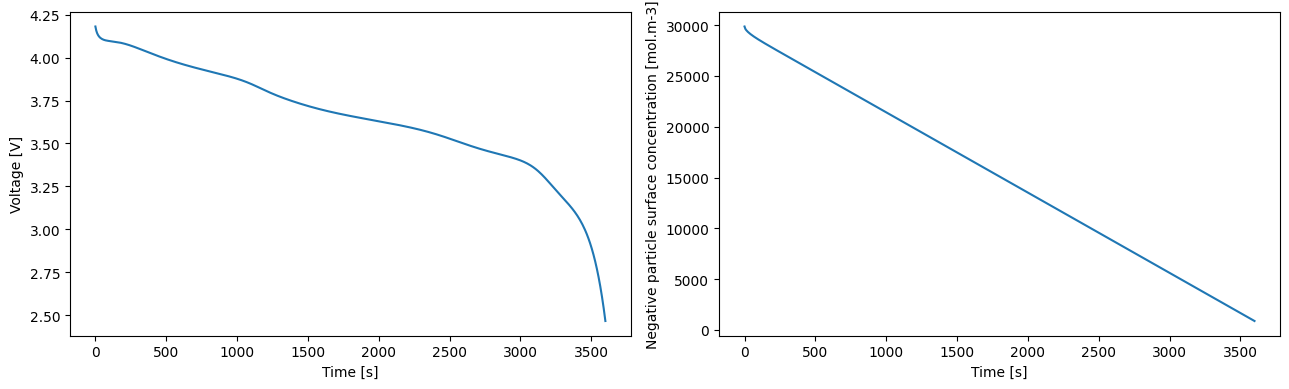

In [21]:
# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 3600, 601)
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
v = solution["Voltage [V]"]
csurf = solution["Negative particle surface concentration [mol.m-3]"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, v(solution.t))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")

ax2.plot(solution.t, csurf(solution.t))
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Negative particle surface concentration [mol.m-3]")

plt.tight_layout()
plt.show()